# Ranked Asset Allocation Model (RAAM) Strategy

**Inspired by:**
- Generalized Momentum by Wouter J. Keller & Hugo van Putten
- Ranked Asset Allocation Model by Gioele Giordano (Dow Award 2018)

This implementation preserves the original strategy logic while improving modularity, readability, and diagnostic capabilities.

## 1. Import Dependencies and Setup

In [389]:
pip install --upgrade numpy pandas yfinance matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [390]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import warnings
from datetime import datetime, timedelta

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Dependencies imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Dependencies imported successfully
Pandas version: 2.3.1
NumPy version: 2.3.2


## 2. Data Downloader Module

In [391]:
class DataDownloader:
    """Handles asset data downloading and preprocessing."""
    
    def __init__(self, start_date: str = "2010-01-01", end_date: Optional[str] = None):
        """
        Initialize the data downloader.
        
        Args:
            start_date: Start date for data download (YYYY-MM-DD)
            end_date: End date for data download (YYYY-MM-DD), defaults to today
        """
        self.start_date = start_date
        self.end_date = end_date or datetime.now().strftime("%Y-%m-%d")
    
    def download_data(self, tickers: List[str]) -> pd.DataFrame:
        """
        Download adjusted close prices for given tickers.
        
        Args:
            tickers: List of ticker symbols
            
        Returns:
            DataFrame with adjusted close prices
        """
        print(f"Downloading data for {len(tickers)} assets from {self.start_date} to {self.end_date}")
        
        try:
            # Download data with error handling
            data = yf.download(tickers, start=self.start_date, end=self.end_date, 
                             progress=False, group_by='ticker', auto_adjust=True, 
                             prepost=True, threads=True)
            
            # Extract prices - handle different data structures
            if len(tickers) == 1:
                if 'Close' in data.columns:
                    prices = data['Close'].to_frame(tickers[0])
                else:
                    prices = data.to_frame(tickers[0])
            else:
                prices_dict = {}
                for ticker in tickers:
                    try:
                        if ticker in data.columns.get_level_values(0):
                            if 'Close' in data[ticker].columns:
                                prices_dict[ticker] = data[ticker]['Close']
                            else:
                                # Fallback to any available price column
                                price_cols = [col for col in data[ticker].columns if col in ['Adj Close', 'Close', 'Adjusted']]
                                if price_cols:
                                    prices_dict[ticker] = data[ticker][price_cols[0]]
                    except (KeyError, AttributeError):
                        print(f"Skipping {ticker} - no valid price data")
                        continue
                
                if not prices_dict:
                    raise ValueError("No valid price data found for any ticker")
                
                prices = pd.DataFrame(prices_dict)
            
            # Filter out tickers with too much missing data (>50%)
            missing_pct = prices.isnull().sum() / len(prices) * 100
            valid_tickers = missing_pct[missing_pct <= 50].index.tolist()
            
            if len(valid_tickers) == 0:
                raise ValueError("No tickers with sufficient data found")
            
            prices = prices[valid_tickers]
            
            # Report on data quality
            dropped_tickers = set(tickers) - set(valid_tickers)
            if dropped_tickers:
                print(f"Dropped {len(dropped_tickers)} tickers due to insufficient data (>50% missing):")
                print(f"  {', '.join(sorted(dropped_tickers))}")
            
            # Forward fill missing data and drop rows with any remaining NaNs
            prices = prices.fillna(method='ffill').dropna()
            
            if len(prices) == 0:
                raise ValueError("No valid data remaining after cleaning")
            
            print(f"Final data shape: {prices.shape}")
            print(f"Valid tickers: {len(prices.columns)}")
            print(f"Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
            
            return prices
            
        except Exception as e:
            print(f"Error downloading data: {e}")
            raise

print("✅ DataDownloader class updated with robust missing data handling")

✅ DataDownloader class updated with robust missing data handling


## 3. Technical Indicators Module

In [392]:
class TechnicalIndicators:
    """Calculates technical indicators used in the ranking system."""
    
    @staticmethod
    def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
        """Calculate Relative Strength Index."""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    @staticmethod
    def calculate_volatility(returns: pd.Series, period: int = 21) -> pd.Series:
        """Calculate rolling volatility (annualized)."""
        return returns.rolling(window=period).std() * np.sqrt(252)
    
    @staticmethod
    def calculate_average_correlation(returns: pd.DataFrame, asset: str, period: int = 63) -> pd.Series:
        """Calculate average correlation of an asset with all other assets."""
        if asset not in returns.columns:
            return pd.Series(index=returns.index, dtype=float)
        
        correlations = [
            returns[asset].rolling(window=period).corr(returns[other_asset])
            for other_asset in returns.columns if other_asset != asset
        ]
        return pd.concat(correlations, axis=1).mean(axis=1) if correlations else pd.Series(0, index=returns.index)
    
    @staticmethod
    def calculate_ma200(prices: pd.Series) -> pd.Series:
        """Calculate 200-day simple moving average (momentum filter)."""
        return prices.rolling(window=200).mean()

print("✅ TechnicalIndicators updated with MA200 calculation")

✅ TechnicalIndicators updated with MA200 calculation


## 4. Ranking Engine Module

In [393]:
class RankingEngine:
    """Implements the asset ranking methodology with MA200 filter."""
    
    def __init__(self, rsi_weight: float = 0.33, vol_weight: float = 0.33, corr_weight: float = 0.34):
        self.rsi_weight = rsi_weight
        self.vol_weight = vol_weight
        self.corr_weight = corr_weight
        if abs((rsi_weight + vol_weight + corr_weight) - 1.0) > 1e-6:
            print("Warning: Factor weights don't sum to 1.0")

    def calculate_all_indicators(self, prices: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        """Calculate all technical indicators including MA200."""
        print("Calculating technical indicators...")
        returns = prices.pct_change()
        
        indicators = {
            'rsi': pd.DataFrame({asset: TechnicalIndicators.calculate_rsi(prices[asset]) 
                                for asset in prices.columns}),
            'volatility': pd.DataFrame({asset: TechnicalIndicators.calculate_volatility(returns[asset]) 
                                      for asset in prices.columns}),
            'correlation': pd.DataFrame({asset: TechnicalIndicators.calculate_average_correlation(returns, asset) 
                                       for asset in prices.columns}),
            'ma200': pd.DataFrame({asset: TechnicalIndicators.calculate_ma200(prices[asset]) 
                                 for asset in prices.columns})
        }
        print(f"Indicators calculated for {len(prices.columns)} assets")
        return indicators
    
    def filter_by_ma200(self, prices: pd.DataFrame, indicators: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """Filter out assets trading below their 200-day MA."""
        last_prices = prices.iloc[-1]
        last_ma200 = indicators['ma200'].iloc[-1]
        valid_assets = last_prices[last_prices > last_ma200].index
        
        if len(valid_assets) < len(prices.columns):
            print(f"MA200 filter excluded {len(prices.columns) - len(valid_assets)} assets")
        
        return prices[valid_assets]

    def calculate_composite_scores(self, indicators: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """Calculate composite ranking scores."""
        rsi_scores = indicators['rsi'] / 100
        vol_scores = 1 - (indicators['volatility'].div(indicators['volatility'].max(axis=1), axis=0))
        corr_scores = 1 - indicators['correlation']
        
        return (self.rsi_weight * rsi_scores.fillna(0.5) + 
                self.vol_weight * vol_scores.fillna(0.5) + 
                self.corr_weight * corr_scores.fillna(0.5))

    def rank_assets(self, scores: pd.DataFrame) -> pd.DataFrame:
        """Rank assets based on composite scores."""
        return scores.rank(axis=1, method='min', ascending=False)

print("✅ RankingEngine updated with MA200 filtering")

✅ RankingEngine updated with MA200 filtering


## 5. Portfolio Constructor Module

In [394]:
class PortfolioConstructor:
    """Handles portfolio weight assignment and construction."""
    
    def __init__(self, top_n: int = 5):
        """
        Initialize portfolio constructor.
        
        Args:
            top_n: Number of top-ranked assets to select
        """
        self.top_n = top_n
    
    def assign_equal_weights(self, rankings: pd.DataFrame) -> pd.DataFrame:
        """
        Assign equal weights to top N ranked assets.
        
        Args:
            rankings: Asset rankings DataFrame
            
        Returns:
            DataFrame of portfolio weights
        """
        weights = pd.DataFrame(0.0, index=rankings.index, columns=rankings.columns)
        
        for date in rankings.index:
            # Get rankings for this date
            date_ranks = rankings.loc[date]
            
            # Remove NaN rankings
            valid_ranks = date_ranks.dropna()
            
            if len(valid_ranks) == 0:
                continue
            
            # Select top N assets
            top_assets = valid_ranks.nsmallest(self.top_n).index
            
            # Assign equal weights
            weight_per_asset = 1.0 / len(top_assets)
            weights.loc[date, top_assets] = weight_per_asset
            
            # Log selection for diagnostics
            if date == rankings.index[-1]:  # Log final selection
                print(f"\nFinal Portfolio Selection ({date.strftime('%Y-%m-%d')}):")
                for i, asset in enumerate(top_assets, 1):
                    rank = valid_ranks[asset]
                    print(f"  {i}. {asset}: Rank {rank:.1f}, Weight {weight_per_asset:.1%}")
        
        return weights

print("PortfolioConstructor class defined")

PortfolioConstructor class defined


## 6. Backtest Engine Module

In [395]:
class BacktestEngine:
    """Handles portfolio backtesting with proper date alignment."""
    
    def __init__(self, rebalance_freq: str = 'M'):
        self.rebalance_freq = rebalance_freq
    
    def run_backtest(self, prices: pd.DataFrame, weights: pd.DataFrame) -> Dict:
        """Run backtest while preserving full date range."""
        # Calculate daily returns
        returns = prices.pct_change()
        
        # Align weights with trading calendar
        if self.rebalance_freq == 'M':
            rebal_weights = weights.resample('M').last()
        elif self.rebalance_freq == 'Q':
            rebal_weights = weights.resample('Q').last()
        else:  # Daily
            rebal_weights = weights
        
        # Forward fill weights on price index
        aligned_weights = rebal_weights.reindex(prices.index, method='ffill')
        
        # Calculate portfolio returns (maintain original index)
        portfolio_returns = (returns * aligned_weights.shift(1)).sum(axis=1)
        valid_returns = portfolio_returns[pd.notna(portfolio_returns)]
        
        # Calculate performance metrics
        cum_returns = (1 + valid_returns).cumprod()
        cum_returns_full = cum_returns.reindex(prices.index, method='ffill')
        
        # Calculate drawdowns
        rolling_max = cum_returns_full.expanding().max()
        drawdown = (cum_returns_full - rolling_max) / rolling_max
        
        # Performance metrics
        total_return = cum_returns.iloc[-1] - 1
        annual_return = (1 + total_return) ** (252/len(valid_returns)) - 1
        annual_vol = valid_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
        max_drawdown = drawdown.min()
        
        return {
            'returns': portfolio_returns,
            'cumulative_returns': cum_returns_full,
            'drawdown': drawdown,
            'metrics': {
                'Total Return': f"{total_return:.1%}",
                'Annual Return': f"{annual_return:.1%}",
                'Annual Volatility': f"{annual_vol:.1%}",
                'Sharpe Ratio': f"{sharpe_ratio:.2f}",
                'Max Drawdown': f"{max_drawdown:.1%}"
            }
        }
        
        return results

print("BacktestEngine class defined")

BacktestEngine class defined


In [396]:
class RAAMStrategy:
    """Main strategy class with MA200 filter toggle."""
    
    def __init__(self, 
                 tickers: List[str],
                 start_date: str = "2010-01-01",
                 end_date: Optional[str] = None,
                 top_n: int = 5,
                 rebalance_freq: str = 'M',
                 use_ma200_filter: bool = True):  # New parameter
        
        self.tickers = tickers
        self.top_n = top_n
        self.use_ma200_filter = use_ma200_filter
        
        # Initialize components
        self.data_downloader = DataDownloader(start_date, end_date)
        self.ranking_engine = RankingEngine()
        self.portfolio_constructor = PortfolioConstructor(top_n)
        self.backtest_engine = BacktestEngine(rebalance_freq)
        self.visualizer = Visualizer()
        
        # Storage for results
        self.prices = None
        self.indicators = None
        self.rankings = None
        self.weights = None
        self.results = None
    
    def run_strategy(self, benchmark_ticker: Optional[str] = None):
        """Execute strategy with optional MA200 filter."""
        print(f"Starting RAAM Strategy {'with' if self.use_ma200_filter else 'without'} MA200 filter")
        
        # 1. Download data
        self.prices = self.data_downloader.download_data(self.tickers)
        
        # 2. Calculate indicators
        self.indicators = self.ranking_engine.calculate_all_indicators(self.prices)
        
        # 3. Apply MA200 filter if enabled
        if self.use_ma200_filter:
            self.prices = self.ranking_engine.filter_by_ma200(self.prices, self.indicators)
            print(f"{len(self.prices.columns)} assets passed MA200 filter")
        
        # Continue with existing pipeline
        scores = self.ranking_engine.calculate_composite_scores(self.indicators)
        self.rankings = self.ranking_engine.rank_assets(scores)
        self.weights = self.portfolio_constructor.assign_equal_weights(self.rankings)
        self.results = self.backtest_engine.run_backtest(self.prices, self.weights)
        self._generate_outputs(benchmark_ticker)

print("✅ RAAMStrategy updated with MA200 toggle")

✅ RAAMStrategy updated with MA200 toggle


In [397]:
## 7. Visualizer Module

In [421]:
class Visualizer:
    """Handles all visualization and performance reporting."""
    
    @staticmethod
    def print_performance_summary(results: Dict):
        """
        Print comprehensive performance metrics.
        
        Args:
            results: Dictionary containing:
                - 'metrics': Dict of performance metrics
                - 'returns': Series of daily returns
                - 'cumulative_returns': Series of cumulative returns
                - 'drawdown': Series of drawdown values
        """
        print("\n" + "="*60)
        print("PERFORMANCE SUMMARY".center(60))
        print("="*60)
        
        # Print key metrics
        metrics = results['metrics']
        print(f"{'Total Return:':<20}{metrics['Total Return']:>15}")
        print(f"{'Annual Return:':<20}{metrics['Annual Return']:>15}")
        print(f"{'Annual Volatility:':<20}{metrics['Annual Volatility']:>15}")
        print(f"{'Sharpe Ratio:':<20}{metrics['Sharpe Ratio']:>15}")
        print(f"{'Max Drawdown:':<20}{metrics['Max Drawdown']:>15}")
        
        # Additional statistics
        returns = results['returns']
        print("\n" + "-"*60)
        print(f"{'First Date:':<20}{returns.index[0].strftime('%Y-%m-%d'):>15}")
        print(f"{'Last Date:':<20}{returns.index[-1].strftime('%Y-%m-%d'):>15}")
        print(f"{'Trading Days:':<20}{len(returns):>15,}")
        print(f"{'Positive Days:':<20}{f'{(returns > 0).mean():.1%}':>15}")
        print(f"{'Best Day:':<20}{f'{returns.max():.2%}':>15}")
        print(f"{'Worst Day:':<20}{f'{returns.min():.2%}':>15}")
        print("="*60)

    @staticmethod
    def plot_equity_curve(results: Dict, benchmark: Optional[pd.Series] = None):
        """Plot equity curve with benchmark comparison."""
        plt.figure(figsize=(14, 7))
        cum_ret = results['cumulative_returns']
        
        # Plot strategy
        plt.plot(cum_ret.index, cum_ret, 
                label='Strategy', linewidth=2, color='#1f77b4')
        
        # Plot benchmark if provided
        if benchmark is not None:
            bench_ret = (1 + benchmark.pct_change()).cumprod()
            bench_ret = bench_ret.reindex(cum_ret.index, method='ffill')
            plt.plot(bench_ret.index, bench_ret,
                    label='Benchmark', linewidth=1.5, color='#7f7f7f', alpha=0.7)
        
        plt.title('Equity Curve', fontsize=16, pad=20)
        plt.ylabel('Cumulative Return', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_drawdown(results: Dict):
        """Visualize portfolio drawdowns."""
        plt.figure(figsize=(14, 4))
        plt.fill_between(results['drawdown'].index,
                        results['drawdown'].values * 100,  # Convert to %
                        color='#d62728', alpha=0.3)
        plt.title('Portfolio Drawdown', fontsize=16, pad=15)
        plt.ylabel('Drawdown (%)', fontsize=12)
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_rolling_metrics(results: Dict, window: int = 252):
        """Plot rolling volatility and Sharpe ratio."""
        returns = results['returns']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        
        # Rolling volatility
        rolling_vol = returns.rolling(window).std() * np.sqrt(252) * 100
        ax1.plot(rolling_vol.index, rolling_vol, color='#ff7f0e')
        ax1.set_ylabel('Volatility (%)', fontsize=10)
        ax1.set_title(f'{window}-Day Rolling Metrics', fontsize=14, pad=20)
        ax1.grid(True, alpha=0.2)
        
        # Rolling Sharpe
        rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(252)
        ax2.plot(rolling_sharpe.index, rolling_sharpe, color='#2ca02c')
        ax2.set_ylabel('Sharpe Ratio', fontsize=10)
        ax2.grid(True, alpha=0.2)
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_weight_heatmap(weights: pd.DataFrame, figsize: tuple = (12, 8)):
        """
        Plot portfolio weights heatmap over time.
        
        Args:
            weights: DataFrame with dates as index and assets as columns
            figsize: Figure dimensions
        """
        plt.figure(figsize=figsize)
        sns.heatmap(
            weights.T, 
            cmap='viridis',
            cbar_kws={'label': 'Weight %'},
            yticklabels=True
        )
        plt.title('Portfolio Weights Heatmap')
        plt.xlabel('Date')
        plt.ylabel('Asset')
        plt.tight_layout()
        plt.show()

print("✅ Visualizer class loaded with all required methods")

✅ Visualizer class loaded with all required methods


## 8. Define Asset Universe

In [422]:
# Define asset universe (example portfolio)
TICKERS = [
    "AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "META", "TSLA", "PEP", "AVGO",
    "COST", "CSCO", "ADBE", "NFLX", "TMUS", "TXN", "CMCSA", "QCOM", "INTC", "HON",
    "AMD", "AMGN", "INTU", "ISRG", "BKNG", "MDLZ", "ADI", "LRCX", "VRTX", "MU",
    "AMAT", "SBUX", "GILD", "MRNA", "ADP", "PANW", "FISV", "CSX", "REGN", "MNST",
    "KLAC", "MAR", "NXPI", "ORLY", "ADSK", "MCHP", "AEP", "KDP", "SNPS",
    "FTNT", "IDXX", "LULU", "EXC", "CTAS", "PAYX", "XEL", "PCAR", "ODFL", "VRSK",
    "WBA", "CDNS", "AZN", "DLTR", "EBAY", "BIIB", "ROST", "CRWD", "CHTR",
    "FAST", "PDD", "ANSS", "MRVL", "TEAM", "WDAY", "BKR", "DDOG", "ZS", "CEG",
    "KHC", "VRSN", "CTSH", "SWKS", "OKTA", "EA", "LCID", "BIDU", "ALGN",
    "MELI", "JD", "LI", "NTES", "ASML", "DXCM", "CPRT"
]



# Strategy parameters
START_DATE = "1998-01-01"
TOP_N = 5
REBALANCE_FREQ = 'M'
BENCHMARK_TICKER = 'QQQ'

print(f"✅ Asset universe defined: {len(TICKERS)} assets")
print(f"Assets: {', '.join(TICKERS)}")
print(f"Strategy parameters:")
print(f"  Start Date: {START_DATE}")
print(f"  Top N: {TOP_N}")
print(f"  Rebalance Frequency: {REBALANCE_FREQ}")
print(f"  Benchmark: {BENCHMARK_TICKER}")

✅ Asset universe defined: 93 assets
Assets: AAPL, MSFT, GOOG, AMZN, NVDA, META, TSLA, PEP, AVGO, COST, CSCO, ADBE, NFLX, TMUS, TXN, CMCSA, QCOM, INTC, HON, AMD, AMGN, INTU, ISRG, BKNG, MDLZ, ADI, LRCX, VRTX, MU, AMAT, SBUX, GILD, MRNA, ADP, PANW, FISV, CSX, REGN, MNST, KLAC, MAR, NXPI, ORLY, ADSK, MCHP, AEP, KDP, SNPS, FTNT, IDXX, LULU, EXC, CTAS, PAYX, XEL, PCAR, ODFL, VRSK, WBA, CDNS, AZN, DLTR, EBAY, BIIB, ROST, CRWD, CHTR, FAST, PDD, ANSS, MRVL, TEAM, WDAY, BKR, DDOG, ZS, CEG, KHC, VRSN, CTSH, SWKS, OKTA, EA, LCID, BIDU, ALGN, MELI, JD, LI, NTES, ASML, DXCM, CPRT
Strategy parameters:
  Start Date: 1998-01-01
  Top N: 5
  Rebalance Frequency: M
  Benchmark: QQQ


## 9. Step 1: Download Data

In [423]:
# Initialize data downloader
data_downloader = DataDownloader(start_date=START_DATE)

# Download asset prices
prices = data_downloader.download_data(TICKERS)

# Display data info
print("\n📊 Data Overview:")
print(f"Shape: {prices.shape}")
print(f"\nFirst few rows:")
print(prices.head())
print(f"\nLast few rows:")
print(prices.tail())
print(f"\nMissing data:")
print(prices.isnull().sum())


1 Failed download:
['FISV']: YFTzMissingError('possibly delisted; no timezone found')


Dropped 16 tickers due to insufficient data (>50% missing):
  CEG, CRWD, DDOG, FISV, JD, KHC, LCID, LI, META, MRNA, OKTA, PANW, PDD, TEAM, WDAY, ZS
Final data shape: (3770, 77)
Valid tickers: 77
Date range: 2010-08-06 to 2025-08-01

📊 Data Overview:
Shape: (3770, 77)

First few rows:
                AAPL       MSFT       GOOG    AMZN      NVDA      TSLA  \
Date                                                                     
2010-08-06  7.816795  19.338102  12.385182  6.4160  0.218919  1.306000   
2010-08-09  7.866683  19.383516  12.512197  6.4415  0.220982  1.306667   
2010-08-10  7.796358  18.974794  12.471593  6.5000  0.211813  1.268667   
2010-08-11  7.519256  18.815851  12.175220  6.2945  0.203560  1.193333   
2010-08-12  7.567345  18.535810  12.181907  6.3280  0.205394  1.173333   

                  PEP      AVGO       COST       CSCO  ...       CTSH  \
Date                                                   ...              
2010-08-06  42.273663  1.597093  40.590977  15.752

## 10. Step 2: Calculate Technical Indicators

In [424]:
# Initialize ranking engine
ranking_engine = RankingEngine()

# Calculate all indicators
indicators = ranking_engine.calculate_all_indicators(prices)

# Display indicator summaries
print("\n📈 Indicator Overview:")
for indicator_name, indicator_df in indicators.items():
    print(f"\n{indicator_name.upper()}:")
    print(f"  Shape: {indicator_df.shape}")
    print(f"  Latest values:")
    latest_values = indicator_df.iloc[-1].dropna()
    for asset, value in latest_values.items():
        print(f"    {asset}: {value:.3f}")

Calculating technical indicators...
Indicators calculated for 77 assets

📈 Indicator Overview:

RSI:
  Shape: (3770, 77)
  Latest values:
    AAPL: 33.280
    MSFT: 68.976
    GOOG: 64.489
    AMZN: 37.719
    NVDA: 63.534
    TSLA: 43.221
    PEP: 55.212
    AVGO: 59.772
    COST: 34.848
    CSCO: 44.054
    ADBE: 28.758
    NFLX: 28.289
    TMUS: 60.258
    TXN: 13.165
    CMCSA: 29.687
    QCOM: 40.713
    INTC: 14.565
    HON: 22.888
    AMD: 74.257
    AMGN: 49.851
    INTU: 61.147
    ISRG: 28.581
    BKNG: 26.363
    MDLZ: 36.350
    ADI: 18.137
    LRCX: 40.886
    VRTX: 43.990
    MU: 27.848
    AMAT: 28.159
    SBUX: 32.917
    GILD: 52.432
    ADP: 45.751
    CSX: 59.772
    REGN: 44.278
    MNST: 46.199
    KLAC: 40.440
    MAR: 19.983
    NXPI: 31.851
    ORLY: 71.994
    ADSK: 53.116
    MCHP: 30.630
    AEP: 76.355
    KDP: 50.469
    SNPS: 69.634
    FTNT: 33.739
    IDXX: 51.787
    LULU: 20.814
    EXC: 60.164
    CTAS: 58.826
    PAYX: 41.439
    XEL: 70.713
    PCAR

In [ ]:
# Initialize ranking engine
ranking_engine = RankingEngine()

# Calculate all indicators
indicators = ranking_engine.calculate_all_indicators(prices)

# Display indicator summaries
print("\n📈 Indicator Overview:")
for indicator_name, indicator_df in indicators.items():
    print(f"\n{indicator_name.upper()}:")
    print(f"  Shape: {indicator_df.shape}")
    print(f"  Latest values:")
    latest_values = indicator_df.iloc[-1].dropna()
    for asset, value in latest_values.items():
        print(f"    {asset}: {value:.3f}")

Calculating technical indicators...
Indicators calculated for 77 assets

📈 Indicator Overview:

RSI:
  Shape: (3770, 77)
  Latest values:
    AAPL: 33.280
    MSFT: 68.976
    GOOG: 64.489
    AMZN: 37.719
    NVDA: 63.534
    TSLA: 43.221
    PEP: 55.212
    AVGO: 59.772
    COST: 34.848
    CSCO: 44.054
    ADBE: 28.758
    NFLX: 28.289
    TMUS: 60.258
    TXN: 13.165
    CMCSA: 29.687
    QCOM: 40.713
    INTC: 14.565
    HON: 22.888
    AMD: 74.257
    AMGN: 49.851
    INTU: 61.147
    ISRG: 28.581
    BKNG: 26.363
    MDLZ: 36.350
    ADI: 18.137
    LRCX: 40.886
    VRTX: 43.990
    MU: 27.848
    AMAT: 28.159
    SBUX: 32.917
    GILD: 52.432
    ADP: 45.751
    CSX: 59.772
    REGN: 44.278
    MNST: 46.199
    KLAC: 40.440
    MAR: 19.983
    NXPI: 31.851
    ORLY: 71.994
    ADSK: 53.116
    MCHP: 30.630
    AEP: 76.355
    KDP: 50.469
    SNPS: 69.634
    FTNT: 33.739
    IDXX: 51.787
    LULU: 20.814
    EXC: 60.164
    CTAS: 58.826
    PAYX: 41.439
    XEL: 70.713
    PCAR

## 11. Step 3: Calculate Composite Scores and Rankings

In [425]:
# Calculate composite scores
scores = ranking_engine.calculate_composite_scores(indicators)

# Calculate rankings
rankings = ranking_engine.rank_assets(scores)

# Display latest scores and rankings
print("\n🎯 Latest Composite Scores and Rankings:")
latest_date = scores.index[-1]
latest_scores = scores.loc[latest_date].dropna().sort_values(ascending=False)
latest_rankings = rankings.loc[latest_date].dropna().sort_values()

print(f"\nDate: {latest_date.strftime('%Y-%m-%d')}")
print(f"\n{'Asset':<6} {'Score':<8} {'Rank':<6}")
print("-" * 20)
for asset in latest_scores.index:
    score = latest_scores[asset]
    rank = latest_rankings[asset]
    print(f"{asset:<6} {score:<8.3f} {rank:<6.1f}")


🎯 Latest Composite Scores and Rankings:

Date: 2025-08-01

Asset  Score    Rank  
--------------------
AEP    0.882    1.0   
WBA    0.858    2.0   
ORLY   0.848    3.0   
XEL    0.846    4.0   
EXC    0.823    5.0   
DLTR   0.808    6.0   
GOOG   0.803    7.0   
MSFT   0.795    8.0   
EBAY   0.790    9.0   
AMD    0.773    10.0  
INTU   0.773    11.0  
EA     0.770    12.0  
TMUS   0.769    13.0  
NVDA   0.758    14.0  
CTAS   0.748    15.0  
ROST   0.747    16.0  
MELI   0.747    17.0  
CDNS   0.738    18.0  
AVGO   0.733    19.0  
KDP    0.732    20.0  
BKR    0.724    21.0  
AZN    0.717    22.0  
SNPS   0.716    23.0  
CSX    0.715    24.0  
COST   0.711    25.0  
AMGN   0.710    26.0  
ADP    0.708    27.0  
FAST   0.708    28.0  
MNST   0.699    29.0  
NTES   0.693    30.0  
PEP    0.690    31.0  
REGN   0.690    32.0  
GILD   0.689    33.0  
CPRT   0.685    34.0  
CSCO   0.685    35.0  
VRTX   0.683    36.0  
VRSN   0.683    37.0  
PAYX   0.682    38.0  
BIDU   0.682    39.0  

## 12. Step 4: Assign Portfolio Weights

In [426]:
# Initialize portfolio constructor
portfolio_constructor = PortfolioConstructor(top_n=TOP_N)

# Assign equal weights to top N assets
weights = portfolio_constructor.assign_equal_weights(rankings)

# Display weight summary
print("\n💼 Portfolio Weights Overview:")
print(f"Shape: {weights.shape}")
print(f"\nWeight statistics:")
print(weights.describe())

# Show weight distribution over time for top assets
weight_sums = weights.sum().sort_values(ascending=False)
print(f"\nTotal weight allocation by asset:")
for asset, total_weight in weight_sums.head(10).items():
    print(f"  {asset}: {total_weight:.1f} (avg {total_weight/len(weights):.1%})")


Final Portfolio Selection (2025-08-01):
  1. AEP: Rank 1.0, Weight 20.0%
  2. WBA: Rank 2.0, Weight 20.0%
  3. ORLY: Rank 3.0, Weight 20.0%
  4. XEL: Rank 4.0, Weight 20.0%
  5. EXC: Rank 5.0, Weight 20.0%

💼 Portfolio Weights Overview:
Shape: (3770, 77)

Weight statistics:
              AAPL         MSFT         GOOG         AMZN         NVDA  \
count  3770.000000  3770.000000  3770.000000  3770.000000  3770.000000   
mean      0.015703     0.007958     0.008488     0.009973     0.003183   
std       0.053803     0.039097     0.040324     0.043540     0.025033   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.200000     0.200000     0.200000     0.200000     0.200000   

              TSLA          PEP         AVGO         COST

## 13. Step 5: Run Backtest

In [427]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [428]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [429]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [430]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [431]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [432]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


## 14. Step 6: Generate Visualizations

### 14.1 Download Benchmark Data

In [433]:
# Download benchmark data
benchmark_prices = None
if BENCHMARK_TICKER:
    try:
        benchmark_data = data_downloader.download_data([BENCHMARK_TICKER])
        benchmark_prices = benchmark_data[BENCHMARK_TICKER]
        print(f"✅ Benchmark data downloaded for {BENCHMARK_TICKER}")
    except Exception as e:
        print(f"❌ Could not download benchmark {BENCHMARK_TICKER}: {e}")

Error downloading data: 'DataFrame' object has no attribute 'to_frame'
❌ Could not download benchmark QQQ: 'DataFrame' object has no attribute 'to_frame'


### 14.2 Equity Curve and Drawdown

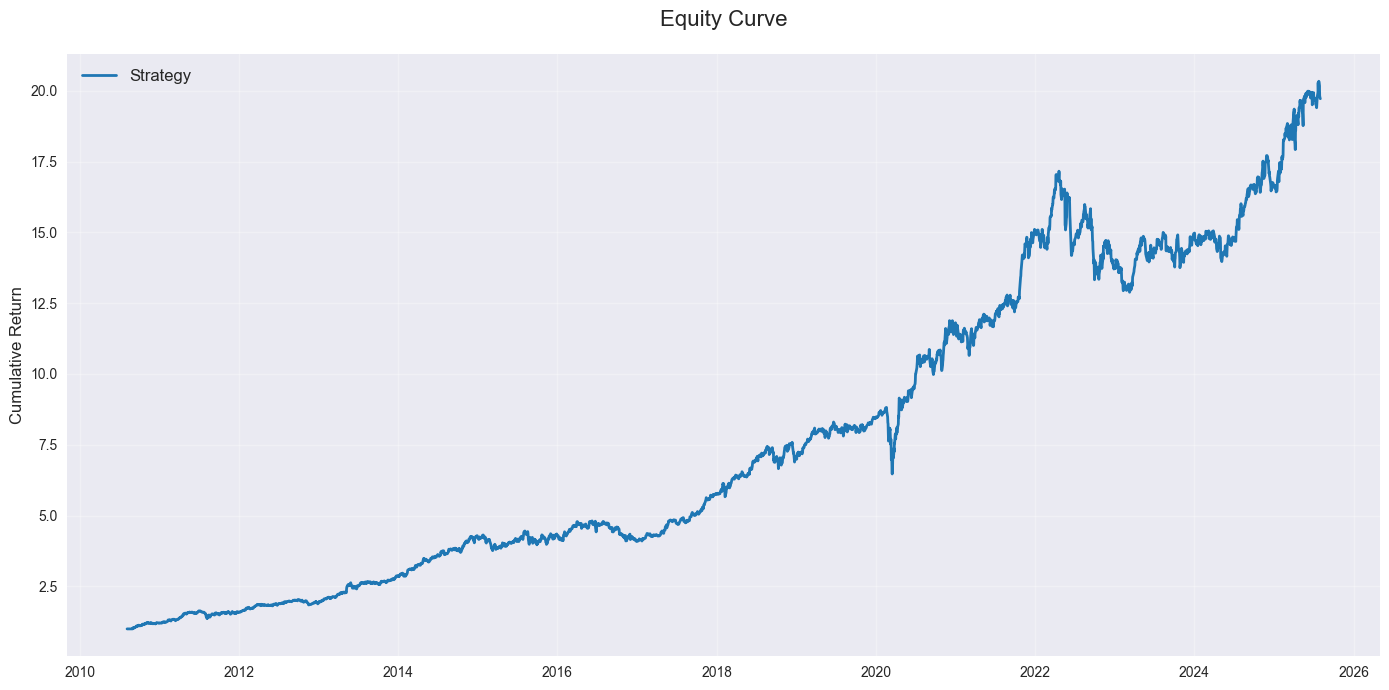

In [434]:
# Plot equity curve vs benchmark
visualizer.plot_equity_curve(results, benchmark_prices)

### 14.3 Rolling Performance Metrics

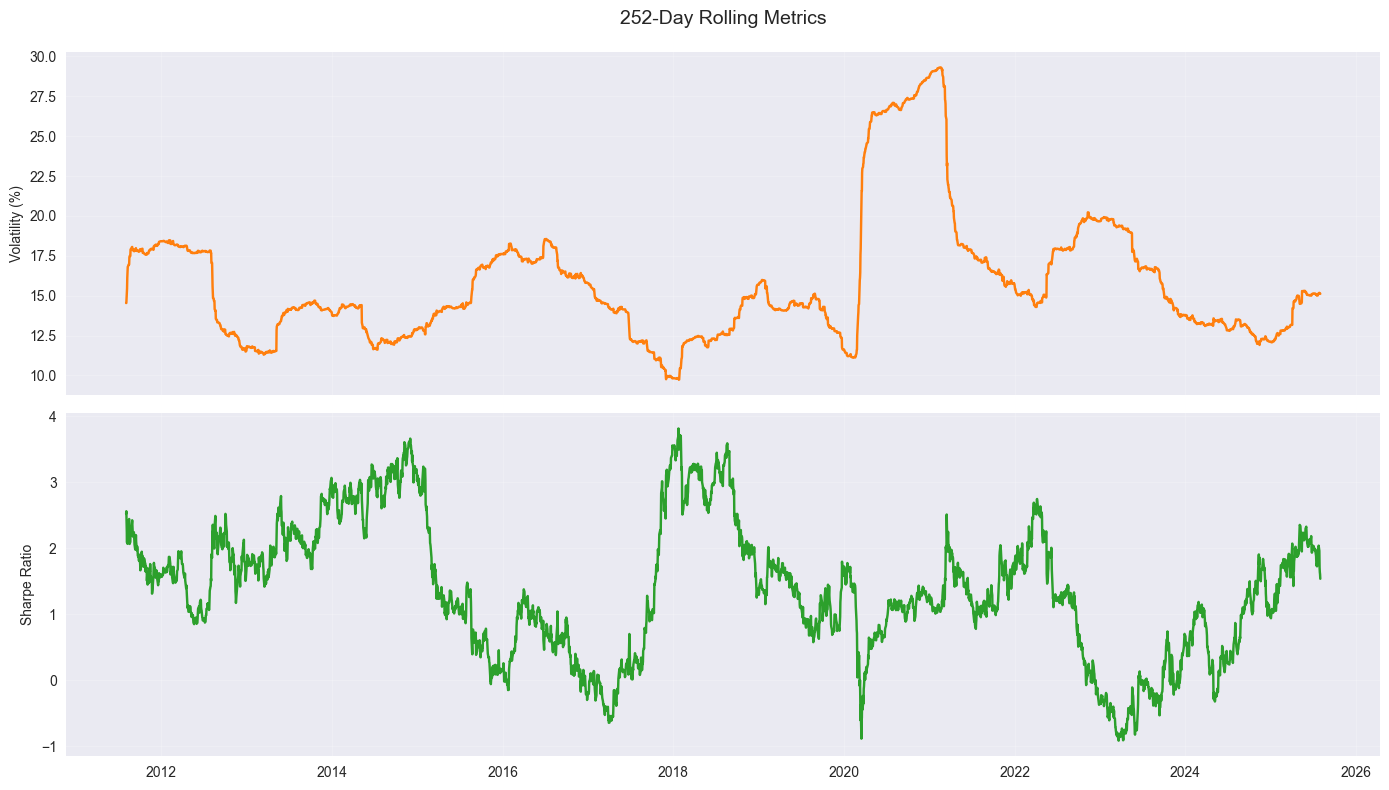

In [435]:
# Plot rolling metrics
visualizer.plot_rolling_metrics(results)

### 14.4 Portfolio Weights Heatmap

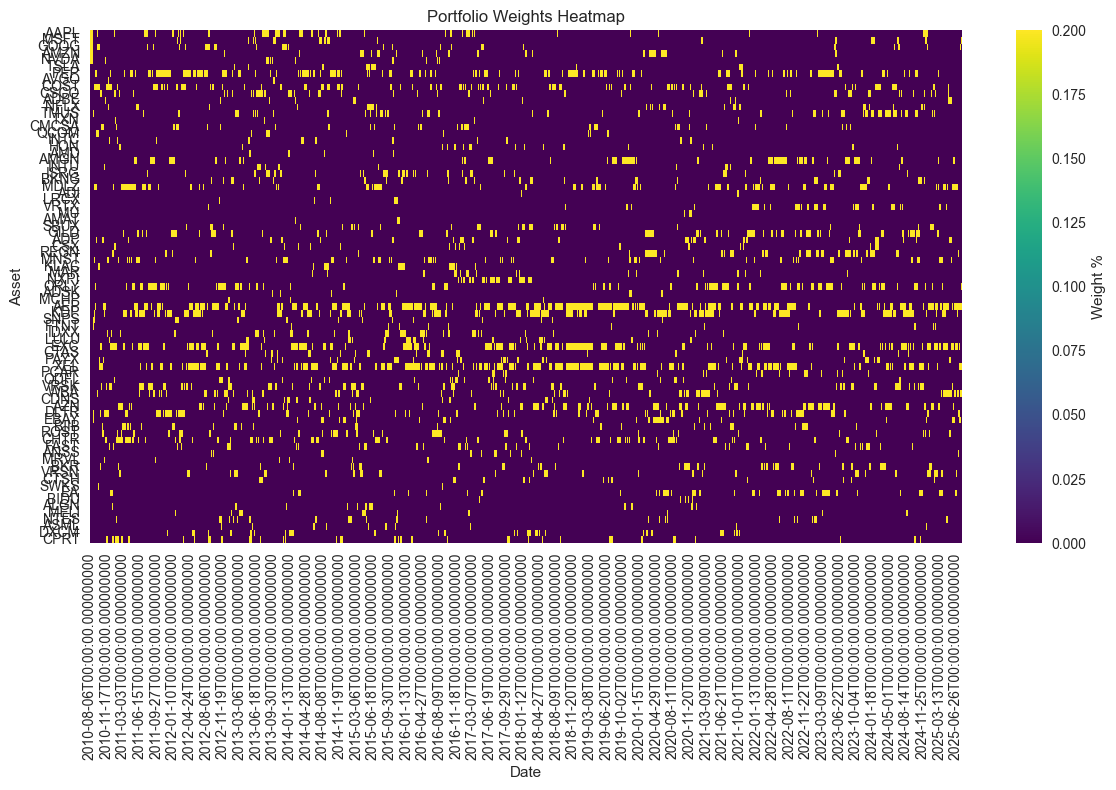

In [436]:
# Plot weights heatmap
visualizer.plot_weight_heatmap(weights)

In [437]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [438]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


In [439]:
# Initialize backtest engine
backtest_engine = BacktestEngine(rebalance_freq=REBALANCE_FREQ)

# Run backtest
results = backtest_engine.run_backtest(prices, weights)

# Display performance summary
visualizer = Visualizer()
visualizer.print_performance_summary(results)


                    PERFORMANCE SUMMARY                     
Total Return:               1872.0%
Annual Return:                22.1%
Annual Volatility:            16.2%
Sharpe Ratio:                  1.36
Max Drawdown:                -26.6%

------------------------------------------------------------
First Date:              2010-08-06
Last Date:               2025-08-01
Trading Days:                 3,770
Positive Days:                55.3%
Best Day:                     7.04%
Worst Day:                  -10.53%


## 15. Step 7: Strategy Diagnostics

In [440]:
def print_diagnostics(indicators, rankings, weights):
    """Print diagnostic information for strategy validation."""
    print("\n" + "="*60)
    print("STRATEGY DIAGNOSTICS")
    print("="*60)
    
    # Check for ranking ties
    final_rankings = rankings.iloc[-1].dropna()
    tied_ranks = final_rankings[final_rankings.duplicated()].index
    if len(tied_ranks) > 0:
        print(f"Warning: Tied rankings detected for assets: {list(tied_ranks)}")
    else:
        print("✅ No tied rankings detected")
    
    # Weight distribution check
    final_weights = weights.iloc[-1]
    selected_assets = final_weights[final_weights > 0]
    print(f"\nFinal Portfolio Allocation:")
    print(f"Selected Assets: {len(selected_assets)}")
    print(f"Weight Distribution: {selected_assets.describe()}")
    
    # Validate equal weighting
    if len(selected_assets) > 1:
        weight_variance = selected_assets.var()
        if weight_variance < 1e-10:
            print("✅ Equal weighting confirmed")
        else:
            print(f"⚠️ Weight variance detected: {weight_variance:.6f}")
    
    # Indicator validation
    print(f"\nIndicator Summary (Final Values):")
    for indicator_name, indicator_df in indicators.items():
        final_values = indicator_df.iloc[-1].dropna()
        print(f"{indicator_name.upper()}:")
        print(f"  Mean: {final_values.mean():.3f}")
        print(f"  Range: {final_values.min():.3f} - {final_values.max():.3f}")
    
    # Validate ranking logic
    print(f"\nRanking Logic Validation:")
    final_date = rankings.index[-1]
    final_scores = scores.loc[final_date].dropna()
    final_ranks = rankings.loc[final_date].dropna()
    
    # Check if highest score gets rank 1
    highest_score_asset = final_scores.idxmax()
    lowest_rank = final_ranks.min()
    lowest_rank_asset = final_ranks.idxmin()
    
    if highest_score_asset == lowest_rank_asset:
        print("✅ Ranking logic validated: Highest score gets best rank")
    else:
        print(f"⚠️ Ranking issue: Highest score ({highest_score_asset}) != Best rank ({lowest_rank_asset})")

# Run diagnostics
print_diagnostics(indicators, rankings, weights)


STRATEGY DIAGNOSTICS
✅ No tied rankings detected

Final Portfolio Allocation:
Selected Assets: 5
Weight Distribution: count    5.0
mean     0.2
std      0.0
min      0.2
25%      0.2
50%      0.2
75%      0.2
max      0.2
Name: 2025-08-01 00:00:00, dtype: float64
✅ Equal weighting confirmed

Indicator Summary (Final Values):
RSI:
  Mean: 44.404
  Range: 11.421 - 78.261
VOLATILITY:
  Mean: 0.303
  Range: 0.043 - 1.334
CORRELATION:
  Mean: 0.191
  Range: -0.082 - 0.340
MA200:
  Mean: 310.220
  Range: 10.573 - 5009.684

Ranking Logic Validation:
✅ Ranking logic validated: Highest score gets best rank


## 16. Additional Analysis

### 16.1 Correlation Analysis

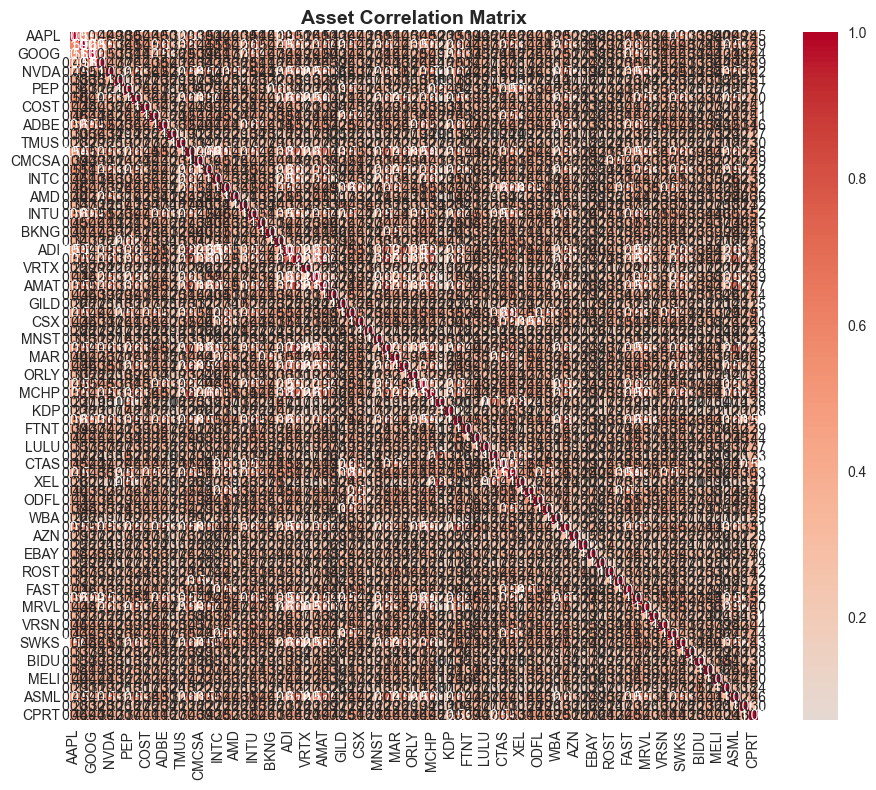


🔗 Highest Correlations:
  LRCX - AMAT: 0.865
  LRCX - KLAC: 0.850
  AMAT - KLAC: 0.829
  ADI - MCHP: 0.824
  TXN - ADI: 0.824

🔗 Lowest Correlations:
  XEL - BIDU: 0.079
  NFLX - AEP: 0.077
  AEP - NTES: 0.073
  AEP - BIDU: 0.067
  TSLA - AEP: 0.060


In [441]:
# Analyze asset correlations
returns = prices.pct_change().dropna()
correlation_matrix = returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show highest and lowest correlations
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        asset1 = correlation_matrix.columns[i]
        asset2 = correlation_matrix.columns[j]
        corr = correlation_matrix.iloc[i, j]
        corr_pairs.append((asset1, asset2, corr))

corr_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n🔗 Highest Correlations:")
for asset1, asset2, corr in corr_pairs[:5]:
    print(f"  {asset1} - {asset2}: {corr:.3f}")

print("\n🔗 Lowest Correlations:")
for asset1, asset2, corr in corr_pairs[-5:]:
    print(f"  {asset1} - {asset2}: {corr:.3f}")

### 16.2 Factor Analysis


📊 Factor Analysis for 2025-08-01:
   Asset     RSI  Volatility  Correlation  Composite_Score  Rank
41   AEP  76.355       0.179       -0.014            0.882   1.0
54   WBA  78.261       0.043        0.177            0.858   2.0
38  ORLY  71.994       0.199        0.031            0.848   3.0
50   XEL  70.713       0.164        0.048            0.846   4.0
47   EXC  60.164       0.162        0.017            0.823   5.0
..   ...     ...         ...          ...              ...   ...
52  ODFL  23.735       0.442        0.288            0.541  73.0
16  INTC  14.565       0.467        0.246            0.519  74.0
13   TXN  13.165       0.498        0.229            0.512  75.0
61  CHTR  11.421       0.701        0.115            0.495  76.0
71  ALGN  24.290       1.334        0.190            0.355  77.0

[77 rows x 6 columns]


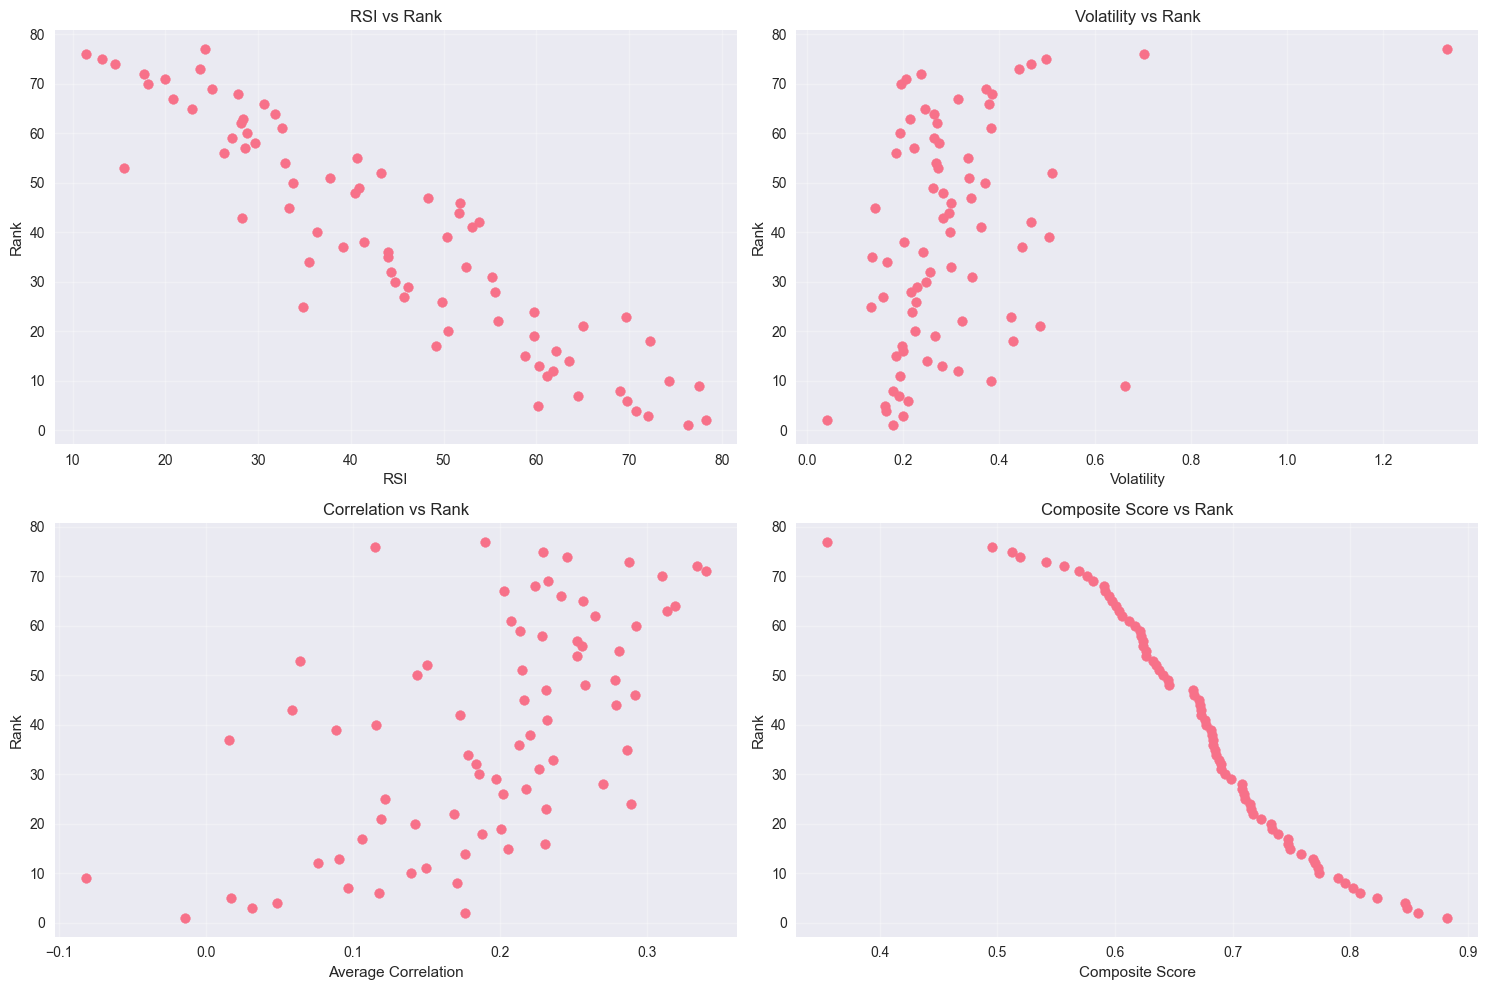

In [442]:
# Analyze factor contributions to final rankings
final_date = indicators['rsi'].index[-1]

factor_data = {
    'Asset': [],
    'RSI': [],
    'Volatility': [],
    'Correlation': [],
    'Composite_Score': [],
    'Rank': []
}

for asset in TICKERS:
    if asset in indicators['rsi'].columns:
        factor_data['Asset'].append(asset)
        factor_data['RSI'].append(indicators['rsi'].loc[final_date, asset])
        factor_data['Volatility'].append(indicators['volatility'].loc[final_date, asset])
        factor_data['Correlation'].append(indicators['correlation'].loc[final_date, asset])
        factor_data['Composite_Score'].append(scores.loc[final_date, asset])
        factor_data['Rank'].append(rankings.loc[final_date, asset])

factor_df = pd.DataFrame(factor_data).sort_values('Rank')

print(f"\n📊 Factor Analysis for {final_date.strftime('%Y-%m-%d')}:")
print(factor_df.round(3))

# Visualize factor contributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RSI vs Rank
axes[0,0].scatter(factor_df['RSI'], factor_df['Rank'])
axes[0,0].set_xlabel('RSI')
axes[0,0].set_ylabel('Rank')
axes[0,0].set_title('RSI vs Rank')
axes[0,0].grid(True, alpha=0.3)

# Volatility vs Rank  
axes[0,1].scatter(factor_df['Volatility'], factor_df['Rank'])
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Rank')
axes[0,1].set_title('Volatility vs Rank')
axes[0,1].grid(True, alpha=0.3)

# Correlation vs Rank
axes[1,0].scatter(factor_df['Correlation'], factor_df['Rank'])
axes[1,0].set_xlabel('Average Correlation')
axes[1,0].set_ylabel('Rank')
axes[1,0].set_title('Correlation vs Rank')
axes[1,0].grid(True, alpha=0.3)

# Composite Score vs Rank
axes[1,1].scatter(factor_df['Composite_Score'], factor_df['Rank'])
axes[1,1].set_xlabel('Composite Score')
axes[1,1].set_ylabel('Rank')
axes[1,1].set_title('Composite Score vs Rank')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Future Enhancement Suggestions

In [443]:
print("\n" + "="*60)
print("FUTURE ENHANCEMENT SUGGESTIONS")
print("="*60)
print("1. Add transaction costs and slippage modeling")
print("2. Implement dynamic lookback periods based on market regime")
print("3. Add risk budgeting constraints")
print("4. Include momentum and mean reversion factors")
print("5. Add regime detection for factor weight adjustment")
print("6. Implement portfolio optimization beyond equal weighting")
print("7. Add sector/geographic constraints")
print("8. Include ESG scoring as additional factor")
print("9. Add Monte Carlo simulation for risk assessment")
print("10. Implement walk-forward optimization for parameter tuning")


FUTURE ENHANCEMENT SUGGESTIONS
1. Add transaction costs and slippage modeling
2. Implement dynamic lookback periods based on market regime
3. Add risk budgeting constraints
4. Include momentum and mean reversion factors
5. Add regime detection for factor weight adjustment
6. Implement portfolio optimization beyond equal weighting
7. Add sector/geographic constraints
8. Include ESG scoring as additional factor
9. Add Monte Carlo simulation for risk assessment
10. Implement walk-forward optimization for parameter tuning
